# Principal component analysis for multi-spectral data <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[s2a_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2a_ard_granule),
[s2b_ard_granule](https://explorer.sandbox.dea.ga.gov.au/s2b_ard_granule)


## Background

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction.
It can be used to explore patterns in high-dimensional data and assist unsupervised learning.

Principal components are a series of linear combinations of the original variables, among which the first principal component accounts for the greatest variance within a dataset.
Each subsequent principal component accounts for the next greatest possible variance and is uncorrelated with the previously defined components.

This technique is useful for understanding Sentinel-2 data as images are captured in 12 spectral bands but only 3 variables can be visualized in a RGB composite.
PCA can also be applied to timeseries data to investigate temporal evolution patterns for different land cover types.

## Description

This notebook demonstrates a principal component analysis for Sentinel-2 multi-spectal data. 
Following steps are covered:

1. Loading Sentinel-2 multi-spectral data.
2. Applying PCA to transform and visualize data.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
from sklearn.decomposition import PCA

import sys
sys.path.append('../Scripts')
from dea_datahandling import load_ard
from dea_plotting import rgb
from dea_classificationtools import sklearn_flatten, sklearn_unflatten

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

Connect to the datacube so we can access DEA data.

In [2]:
dc = datacube.Datacube(app='Principal_component_analysis')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


### Analysis parameters

This section defines the analysis parameters, including 

* `lat, lon`: center lat/lon for the area of interest
* `buffer`: the indow size around the centre lat/lon for the area of interest
* `time_range`: time period to be investigated
* `min_gooddata`: minimumum fraction of good-data in the image before it while be returned
* `bands`: spectral bands to be explored

The default location is the Norman River, Qld.

To limit overall memory usage, if a larger analysis window or higher resolution is desired, the time period should be reduced accordingly.

In [3]:
lat, lon = -17.5687, 140.9653
buffer = 0.075
time_range = ('2019-12', '2020-03')
bands = [
    'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_red_edge_1', 'nbart_red_edge_2',
    'nbart_red_edge_3', 'nbart_nir_2', 'nbart_swir_2', 'nbart_swir_3'
]
min_gooddata = 0.9

## Loading cloud-masked Sentinel-2 multi-spectral data


In [4]:
# Define the query dict
query = {
    'time': time_range,
    'x': (lon - buffer, lon + buffer),
    'y': (lat + buffer, lat - buffer),
    'output_crs': 'epsg:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day',
    'measurements': bands
}

In [5]:
# Load the data
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              min_gooddata=min_gooddata,
              mask_pixel_quality=False,
              **query)

Finding datasets
    s2a_ard_granule
    s2b_ard_granule
Counting good quality pixels for each time step
Filtering to 3 out of 24 time steps with at least 90.0% good quality pixels
Loading 3 time steps


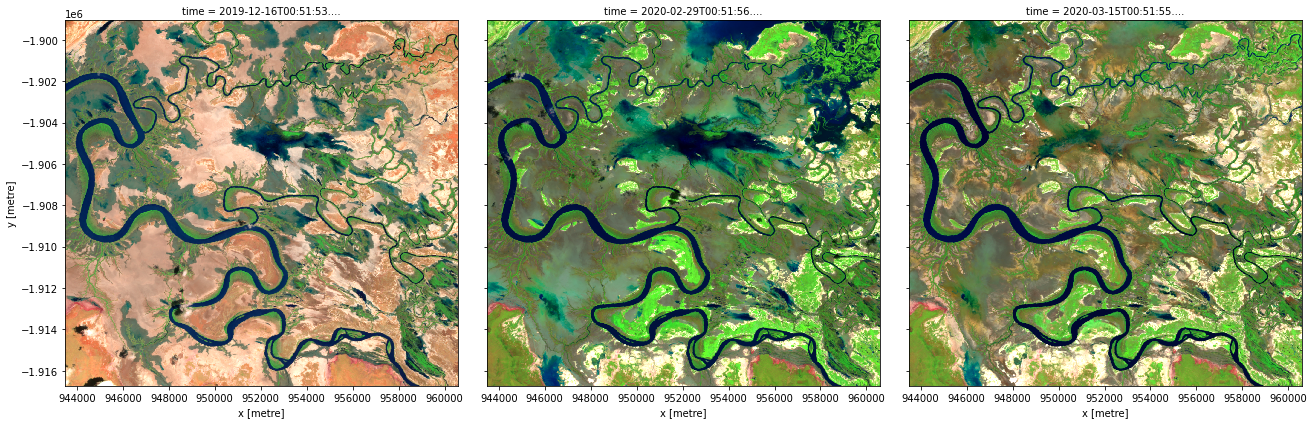

In [6]:
# Visualize data using selected input spectral bands
rgb(ds,
    bands=['nbart_swir_2', 'nbart_nir_2', 'nbart_red_edge_1'],
    col='time',
    col_wrap=3)

## Applying PCA to transform and visualize data

To perform a PCA, data is first transformed into a numpy array that can be used by sklearn using the DEA function `sklearn_flatten`.

In [7]:
x = sklearn_flatten(ds)

A PCA model is generated with 3 principal components and fitted on the data.

In [8]:
pca = PCA(n_components=3)
pca.fit(x)

PCA(n_components=3)

We can investigate how much variance is accounted for in each principal component.
In the default example, the first principal component accounts for a much high variance than the next two.

This step can help determine whether more principal components are needed.

In [9]:
print('Relative variance in principal components:',
      pca.explained_variance_ratio_)

Relative variance in principal components: [0.82989822 0.1061546  0.05487372]


The input data can now be transformed into this new reference space and rearranged into an `xarray.Dataset` compatible with our input data.

In [10]:
predict = pca.transform(x)

In [11]:
out = sklearn_unflatten(predict, ds)
out = out.to_dataset(dim=out.dims[0]).transpose('time', 'y', 'x')

### Visualise PCA results

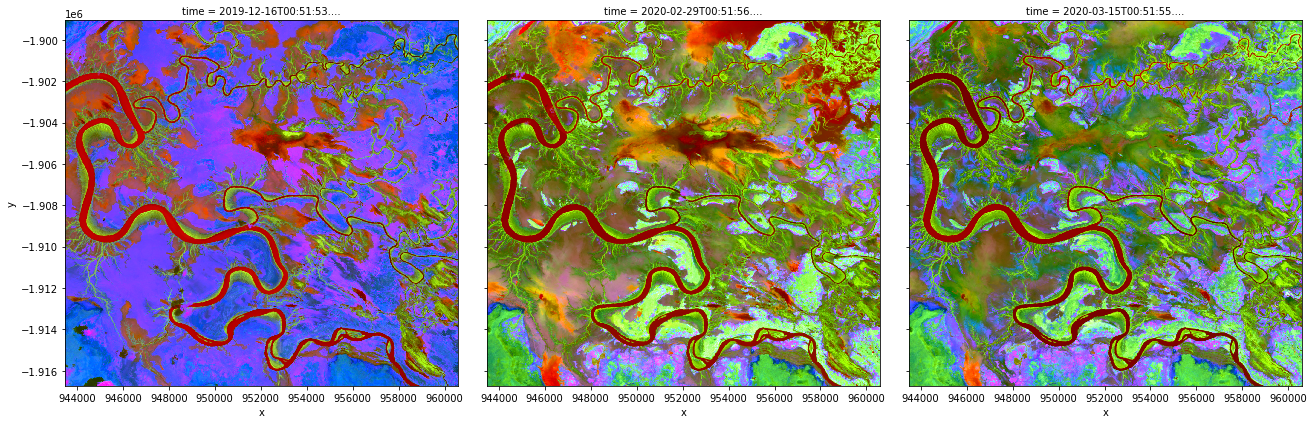

In [12]:
# Plot PCA bands
rgb(out,
    bands=[2, 1, 0],
    col='time',
    col_wrap=3,
    percentile_stretch=[0.08, 0.92])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2021

**Compatible datacube version:** 

In [13]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)